In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd


columns = [
    "age",
    "sex",
    "chest pain type",
    "resting blood pressure",
    "serum cholestoral in mg/dl",
    "fasting blood sugar > 120 mg/dl",
    "resting electrocardiographic results",
    "maximum heart rate achieved",
    "exercise induced angina",
    "oldpeak = ST depression induced by exercise relative to rest",
    "the slope of the peak exercise ST segment",
    "number of major vessels (0-3) colored by flourosopy",
    "thal",
    "target",
]
data = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat",
    header=None,
    sep=" ",
)
data.columns = columns

categorical_columns = [
    "sex",
    "chest pain type",
    "fasting blood sugar > 120 mg/dl",
    "resting electrocardiographic results",
    "thal",
    "exercise induced angina",
]

for c in categorical_columns:
    data[c] = data[c].astype("category")
else:
    data[c] = data[c].astype(float)

data["target"] = np.where(data["target"] == 2, 1, 0)

features = [c for c in columns if c != "target"]
X = data[features]


y = data["target"]

In [3]:
X

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,thal
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [5]:
from scorepyo.preprocessing import AutoBinarizer


binarizer = AutoBinarizer(max_number_binaries_by_features=3, keep_negative=True)
binarizer.fit(
    X_train, y_train, categorical_features=categorical_columns, to_exclude_features=None
)

X_train_binarized = binarizer.transform(X_train)
X_test_binarized = binarizer.transform(X_test)

In [6]:
# binarizer.df_score_feature

# TODO

* put calibration set to see if that helps to robustify logloss on test set
    * on all ocnvex optimization
    * only on last one?
* check on another dataset
* delete optunarisk score, ebmriskscore
* clean ebmriskscorenew
* rework documentation
* write whitepaper
* improve time (one cnvex model?)

In [19]:
from scorepyo.models import EBMRiskScore, OptunaRiskScore,EBMRiskScoreNew
optimization_options = {"nb_additional_features":2}
ebm_model = EBMRiskScoreNew(optimization_options=optimization_options, min_point_value=-2, max_point_value=3, optimization_metric='average_precision')
ebm_model.fit(X_train, y_train, categorical_features=categorical_columns)

0.0
0.8856464381659754
[-2.  1.  2. -2.]

0.887230841328763
[-2.  3.  3. -1.]

0.8935614692937507
[-2.  3.  2. -1.]

0.893061348165804
[-2.  2.  2. -1.]

0.8915889380598864
[-2.  2.  1. -1.]

0.8901552154603821
[-2.  2.  1. -2.]

0.8917960378304236
[-2.  3.  1. -2.]

0.8888386023924403
[-2.  3.  1. -1.]

0.8942380416639251
[-2.  3.  2. -2.]

0.8902312417767076
[-2.  3.  3. -2.]

0.8942380416639251
[-2.  3.  2. -2.]
0.33558198789819993


0.14285714285714285
0.2857142857142857
0.42857142857142855


c:\Users\S5384228\Anaconda3\envs\env_scorepyo_without_setuppy\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.5714285714285714
0.7142857142857143
0.8571428571428571


In [20]:
ebm_model.summary()

| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5 | number of major vessels (0-3) colored by flourosopy < 0.5 | -2.0       | ...   |
| sex_0.0                                                   | sex_0.0                                                   | -2.0       | + ... |
| the slope of the peak exercise ST segment < 1.5           | the slope of the peak exercise ST segment < 1.5           | -1.0       | + ... |
| chest pain type_4.0                                       | chest pain type_4.0                                       | 2.0        | + ... |
|                                                           |                                                          

avec sorted_proba logloss = 0.336 sur train/0.44 sur test

avec iso sorted proba logloss = 0.336 train/0.448 sur test

avec cvx opt logloss = 0.336 / 0.448

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss
y_proba = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
logloss

0.333

In [22]:
y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
logloss

0.507

In [23]:
ebm_model.summary()

| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5 | number of major vessels (0-3) colored by flourosopy < 0.5 | -2.0       | ...   |
| sex_0.0                                                   | sex_0.0                                                   | -2.0       | + ... |
| the slope of the peak exercise ST segment < 1.5           | the slope of the peak exercise ST segment < 1.5           | -1.0       | + ... |
| chest pain type_4.0                                       | chest pain type_4.0                                       | 2.0        | + ... |
|                                                           |                                                          

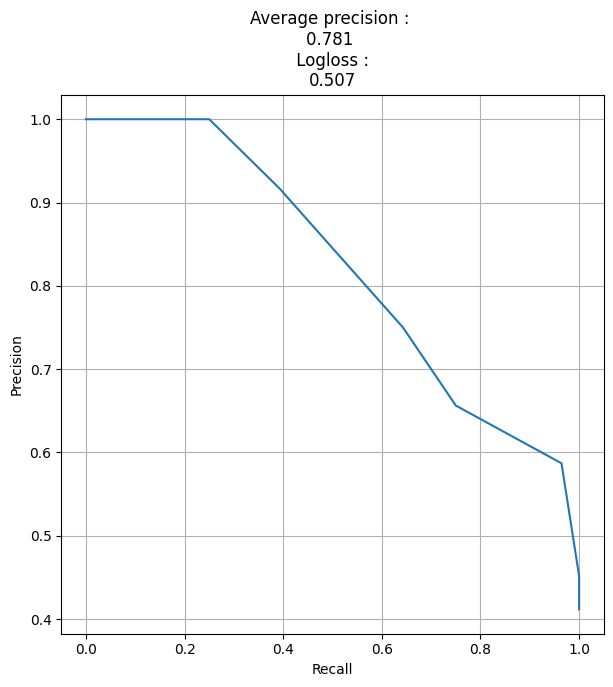

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss


y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [25]:
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

sparsity = 4
parent_size = 10
y_train_fasterrisk = np.where(y_train == 0, -1, 1)
RiskScoreOptimizer_m = RiskScoreOptimizer(
    X=X_train_binarized.values,
    y=y_train_fasterrisk,
    lb=-2,
    ub=3,
    k=4,
    parent_size=parent_size,
)

RiskScoreOptimizer_m.optimize()

(
    multipliers,
    sparseDiversePool_beta0_integer,
    sparseDiversePool_betas_integer,
) = RiskScoreOptimizer_m.get_models()

model_index = 0  # first model
multiplier = multipliers[model_index]
intercept = sparseDiversePool_beta0_integer[model_index]
coefficients = sparseDiversePool_betas_integer[model_index]

RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients)

(202, 50)


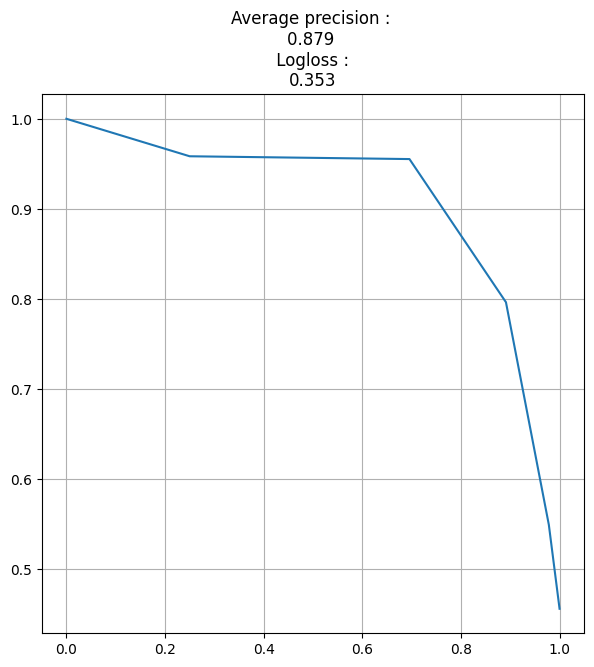

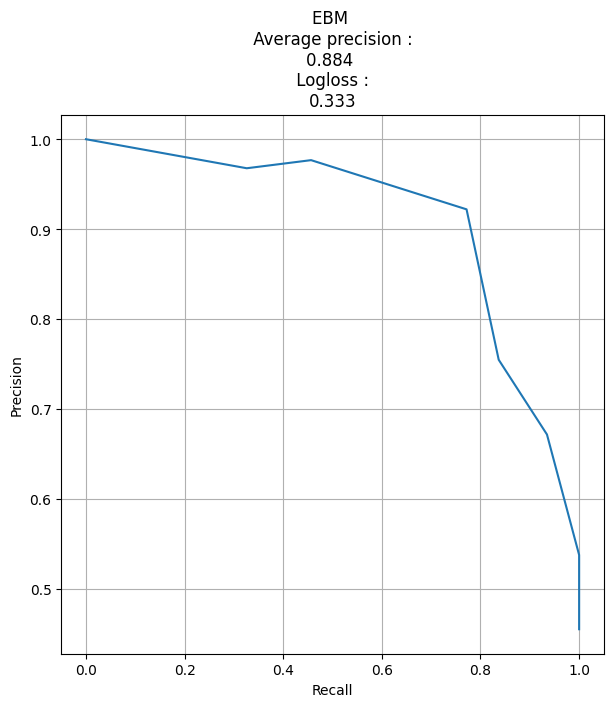

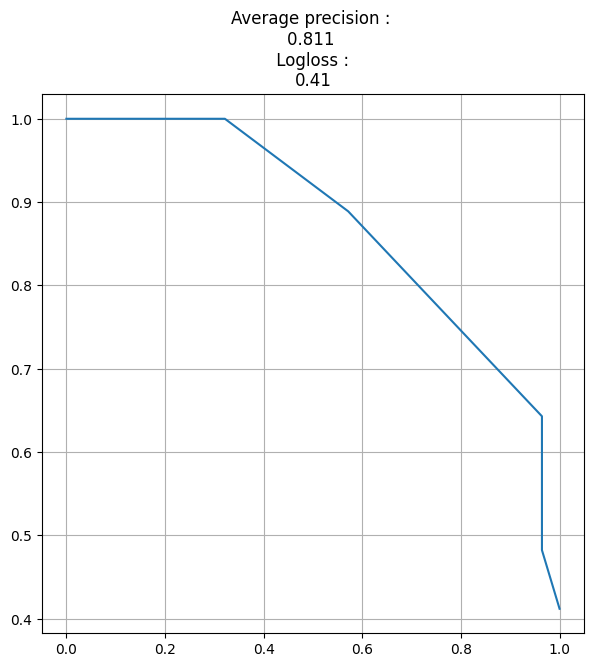

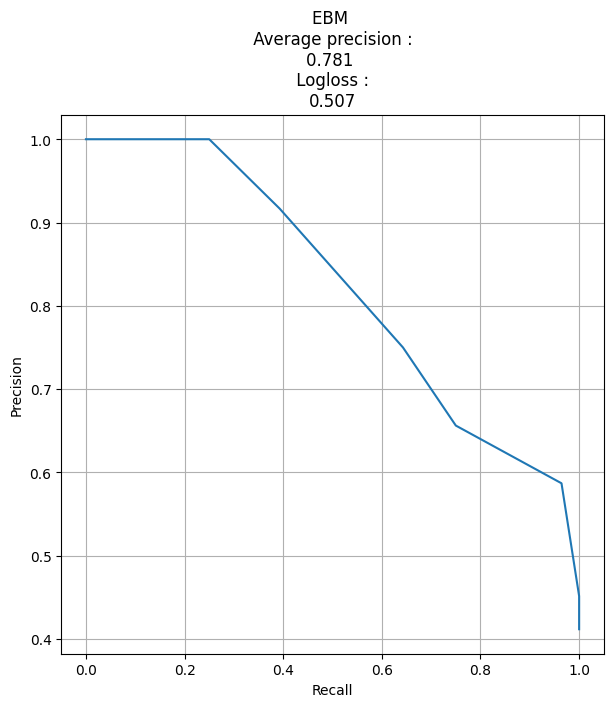

The Risk Score is:
1.                             the slope of the peak exercise ST segment < 1.5     -1 point(s) |   ...
2.                   number of major vessels (0-3) colored by flourosopy < 0.5     -1 point(s) | + ...
3.                                                         chest pain type_4.0      1 point(s) | + ...
4.                                                                    thal_7.0      1 point(s) | + ...
                                                                                         SCORE | =    
SCORE |  -2.0  |  -1.0  |   0.0  |
RISK  |   2.2% |  13.0% |  50.0% |
SCORE |   1.0  |   2.0  |
RISK  |  87.0% |  97.8% |
| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) col

In [26]:
y_proba = RiskScoreClassifier_m.predict_prob(X_train_binarized.values)

precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.grid()
plt.show()

y_proba = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_train.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"EBM \n Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()



y_proba = RiskScoreClassifier_m.predict_prob(X_test_binarized.values)

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.grid()
plt.show()






y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"EBM \n Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

X_featureNames = list(X_train_binarized.columns[:])

RiskScoreClassifier_m.reset_featureNames(X_featureNames)
RiskScoreClassifier_m.print_model_card()

ebm_model.summary()

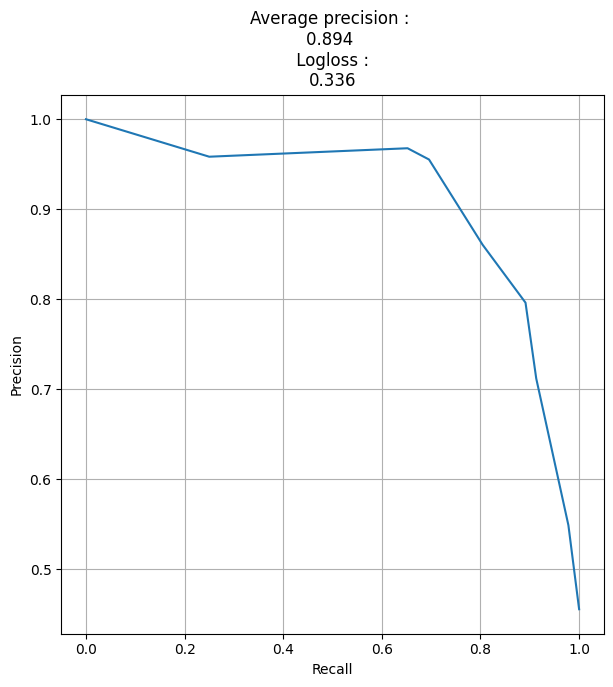

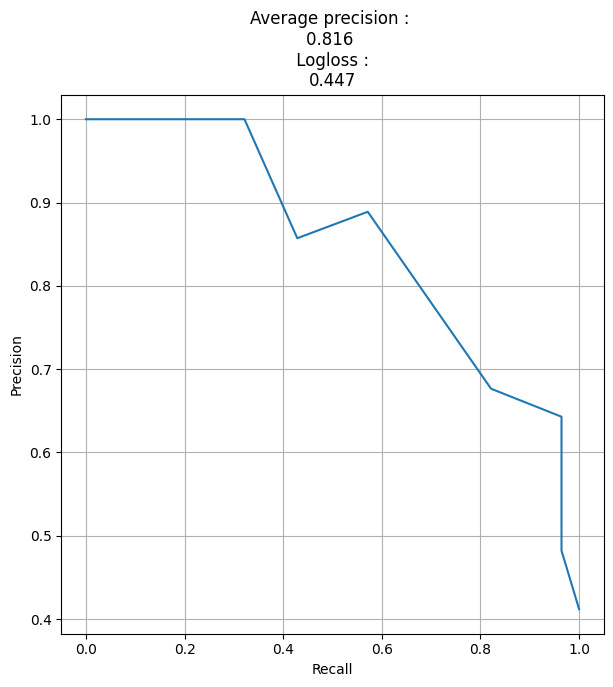

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss

y_proba = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_train.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()